# Torch vs Keras
Lo primero que hay que decir es que Keras es sólo un wrapper. Puede utilizar como motor tensorflow, pytorch, cntk, theano, etc con solo hacer os.environ["KERAS_BACKEND"] = "torch"
En cuanto all MNIST dataset se puede descargar desde varias plataformas.
1. Con sckitlearn mnist = sklearn.datasets.fetch_openml('mnist_784', version=1, as_frame=False) es un diccionario, X, y = mnist["data"], mnist["target"] crea una matriz X de 70000 filas por 784 columnas donde cada fila son los 28x28 pixeles en escala de 0 a 255
2. (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data() me devuelve train_images como un array unidimensional con todas las muestras seguidas unas detrás de otras
3. content = requests.get("https://github.com/pytorch/tutorials/raw/main/_static/mnist.pkl.gz").content descarga un array numpy serializado utilizando pickle que descomprimimos fácilmente con: with gzip.open((PATH / FILENAME).as_posix(), "rb") as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [17]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Fíjate que se puede aplicar una transformada directamente antes de cargar los datos del fichero a una variable. Si el fichero ya está en disco no se descarga. En este caso lo que hacemos es crear un tensor a partir del array. Observa también que cada uno de los datasets es en realidad una tupla dato, etiqueta.

In [9]:
# pre-processor
transform = transforms.Compose([
    #transforms.RandomRotation(30),
    #transforms.RandomResizedCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomHorizontalFlip(),
    #transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))
])

# load the data
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
labels = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')



train_dataset y test_dataset son objetos de tipo Dataset una tupla de dos tensores o dos arrays, uno con los datos y el otro con las etiquetas. En este caso aplicamos una transformación a los datos leídos del fichero para convertir los array de numpy en un tensor de torch pero si ya tenemos los array de numpy y queremos crear un dataset a partir de ellos solo tendriamos que hacer:
### Create torch Datasets from numpy arrays
>train_dataset = torch.utils.data.TensorDataset(  
&nbsp;&nbsp;&nbsp;&nbsp;torch.from_numpy(x_train), torch.from_numpy(y_train)  
)  
val_dataset = torch.utils.data.TensorDataset(  
&nbsp;&nbsp;&nbsp;&nbsp;torch.from_numpy(x_val), torch.from_numpy(y_val)  
)

Fíjate en este ejemplo de un custom Dataset que obtiene las muestras de un csv (annotations_file) que tiene parejas: img_file_name, label y ficheros guardados en la carpeta img_dir con las imágenes.

In [10]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Es fácil visualizar el contenido de los datasets puesto que en realidad son dos tensores. Un tensor es algo parecido a una matriz pero si especificamos `required_grad=True` cada posición tendrá asociado también un gradiente.

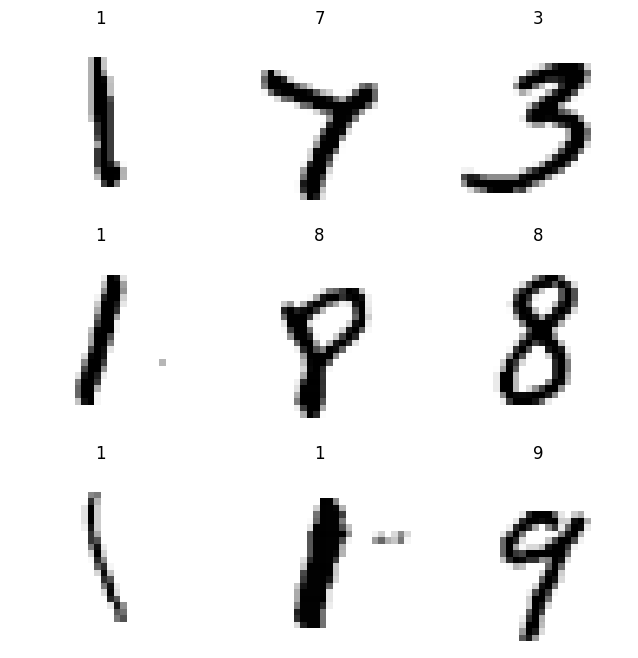

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap=mpl.cm.binary)
plt.show()

Ahora pasamos el dataset como argumento a un DataLoader que permitirá iterar sobre sus elementos, reordenarlos, dividirlos en bloques, etc.

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


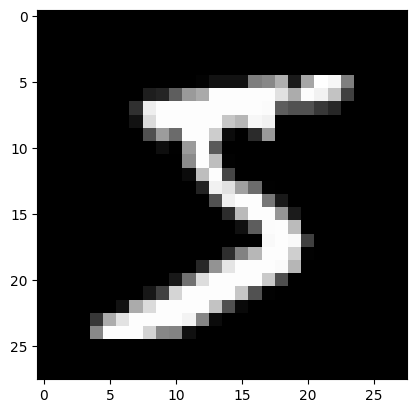

Label: 5


In [12]:
from torch.utils.data import DataLoader
# make loaders for data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels[label]}")

Ahora vamos a crear una red neuronal feedforward con 128, 64 y 10 nodos con activaciones relu desde cero

In [22]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(labels))
        )

    def forward(self, x):
        # En caso de recibir una matriz 28x28 me aseguro de aplanarla a 784
        x = self.flatten(x)
        # Los valores salientes todavía no son probabilidades
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


En lugar de usar Sequential __init__ define únicamente los pesos y forward se encarga de enlazar la salida de una capa con la otra interponiendo las activaciones.

In [18]:
# Define the PyTorch model class
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(784, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, len(labels))

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


Fíjate que la última capa tiene una activación lineal así que no me da probabilidades. Pero aún me falta definir la función de pérdida. Al definir la entropía cruzada como función de pérdida ya lo solucionamos porque CrossEntropyLoss en realidad lo que hace es aplicar una capa softmax. El algoritmo de optimización es el gradiente estocástico.

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

La función train lleva a cabo un epoch: Forward, Calculate loss, backpropagate loss, update weights, reset gradients
Cada 100 iteraciones (minibatch) muestra resultados

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward
        pred = model(X)
        # Calculate loss
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # Zero the parameter gradients
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Pero ya sabemos que el error en el train set no es lo importante sino el error en el test set. Fíjate que al evaluar no queremos que se calcule el gradiente y por eso usamos torch.no_grad

In [29]:
def test(dataloader, model, loss_fn):
    # Dos listas con el número de predicciones a cero
    correct_pred = [0]*len(labels)
    total_pred = [0]*len(labels)
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        # Para cada minibatch
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            # Para cada fila me da el índice de la columna con el valor más grande
            predictions = outputs.argmax(1)
            test_loss += loss_fn(outputs, y).item()
            # Crea una lista de booleanos a True en los ejemplos en los que hay coincidencia y los pasa a float para sumarlos en un array de una posicion
            # correct += (predictions == y).type(torch.float).sum().item()
            # collect the correct predictions for each class
            for label, prediction in zip(y, predictions):
                if label == prediction:
                    correct_pred[label] += 1
                # Acumula el número de ejemplos de cada etiqueta
                total_pred[label] += 1

    test_loss /= num_batches
    correct = sum(correct_pred)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # print accuracy for each class
    for idx, correct_count in enumerate(correct_pred):
        accuracy = 100 * float(correct_count) / total_pred[idx]
        print(f'Accuracy for class: {labels[idx]:5s} is {accuracy:.1f} %')

Si llamamos a la función que entrena ya la que evalua una seguida de otra para cada epoch

In [22]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296434  [   32/60000]
loss: 2.283089  [ 3232/60000]
loss: 2.211408  [ 6432/60000]
loss: 2.173044  [ 9632/60000]
loss: 2.165689  [12832/60000]
loss: 2.013448  [16032/60000]
loss: 1.500696  [19232/60000]
loss: 1.352682  [22432/60000]
loss: 1.013193  [25632/60000]
loss: 0.701278  [28832/60000]
loss: 0.741578  [32032/60000]
loss: 0.671140  [35232/60000]
loss: 0.604895  [38432/60000]
loss: 0.573912  [41632/60000]
loss: 0.491948  [44832/60000]
loss: 0.458725  [48032/60000]
loss: 0.479735  [51232/60000]
loss: 0.365209  [54432/60000]
loss: 0.356890  [57632/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.446107 

Epoch 2
-------------------------------
loss: 0.578468  [   32/60000]
loss: 0.565349  [ 3232/60000]
loss: 0.454970  [ 6432/60000]
loss: 0.374543  [ 9632/60000]
loss: 0.311543  [12832/60000]
loss: 0.566003  [16032/60000]
loss: 0.262239  [19232/60000]
loss: 0.298342  [22432/60000]
loss: 0.298904  [25632/60000]
loss: 0.192156  [28832/60000

Salvamos el modelo

In [23]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to data/model.pth")

Saved PyTorch Model State to data/model.pth


Y lo cargamos de nuevo. Para ello es necesario recrear la estructura del modelo.

In [25]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("data/model.pth", weights_only=True))

<All keys matched successfully>

In [30]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.331357 

Accuracy for class: 0     is 97.8 %
Accuracy for class: 1     is 98.1 %
Accuracy for class: 2     is 84.7 %
Accuracy for class: 3     is 88.9 %
Accuracy for class: 4     is 92.3 %
Accuracy for class: 5     is 87.2 %
Accuracy for class: 6     is 91.9 %
Accuracy for class: 7     is 86.4 %
Accuracy for class: 8     is 82.1 %
Accuracy for class: 9     is 91.5 %
